In [2]:
import pickle

import numpy as np
import pandas as pd

import hist
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep
%matplotlib inline
mpl.style.use(mplhep.style.ROOT)

In [7]:
from pyidm import rate
rate.darkphoton_production(0.6*50.0)*0.0001

1428604332.8215668

In [4]:
with open('conv-vertex-ana.pkl','rb') as f:
    d = pickle.load(f)

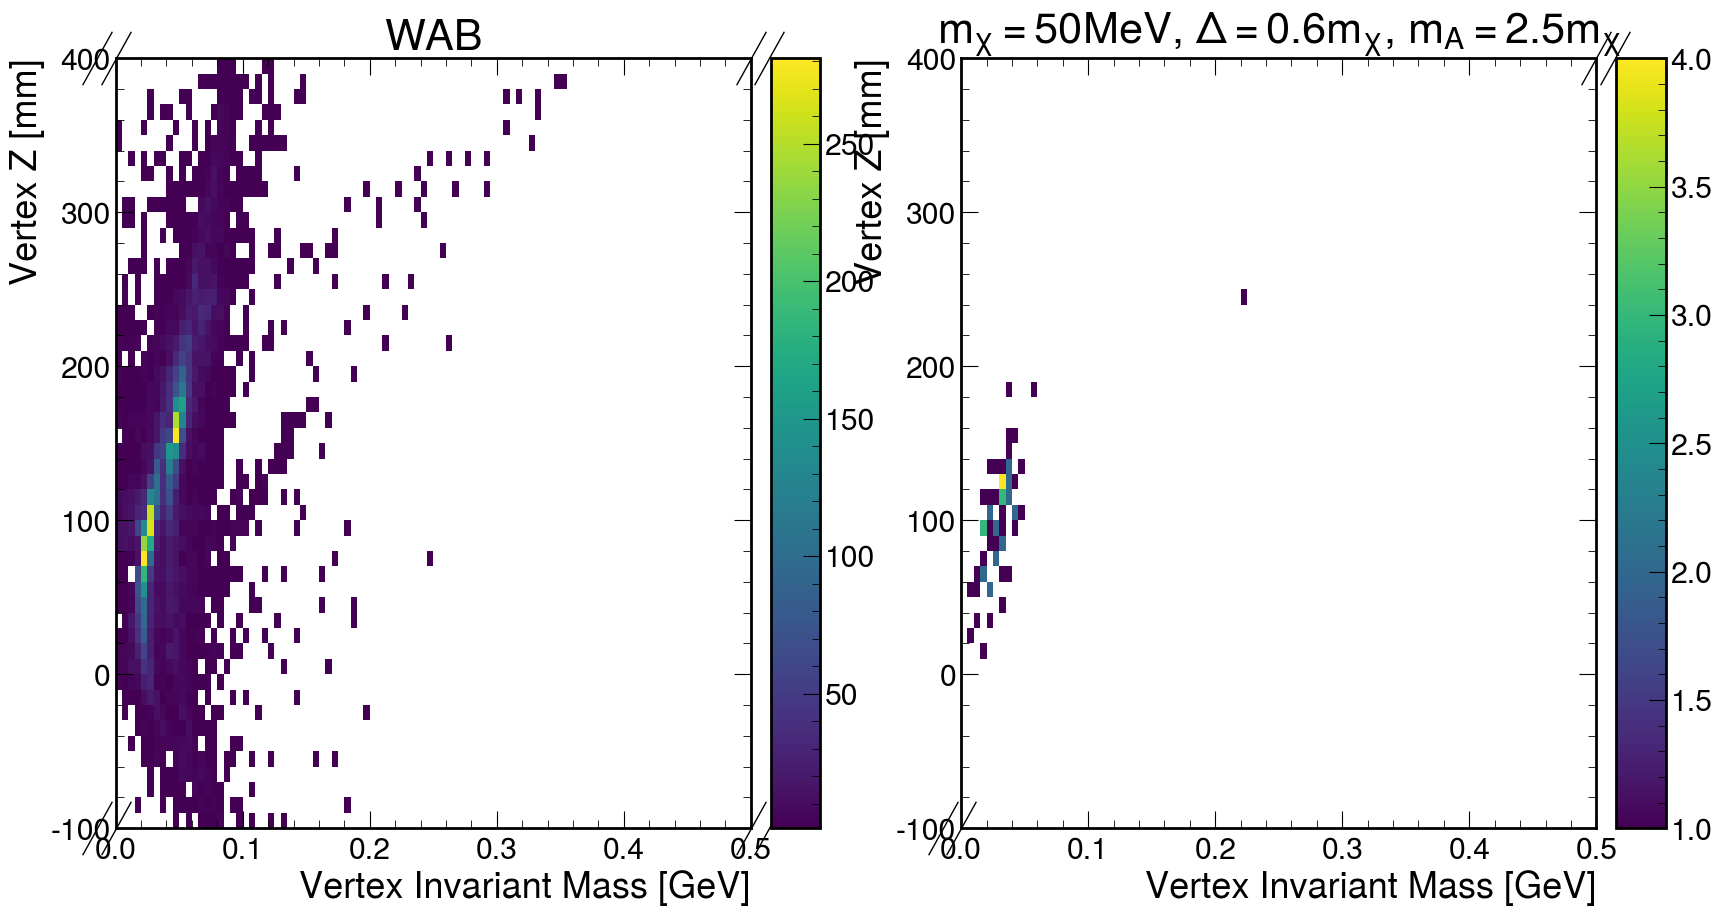

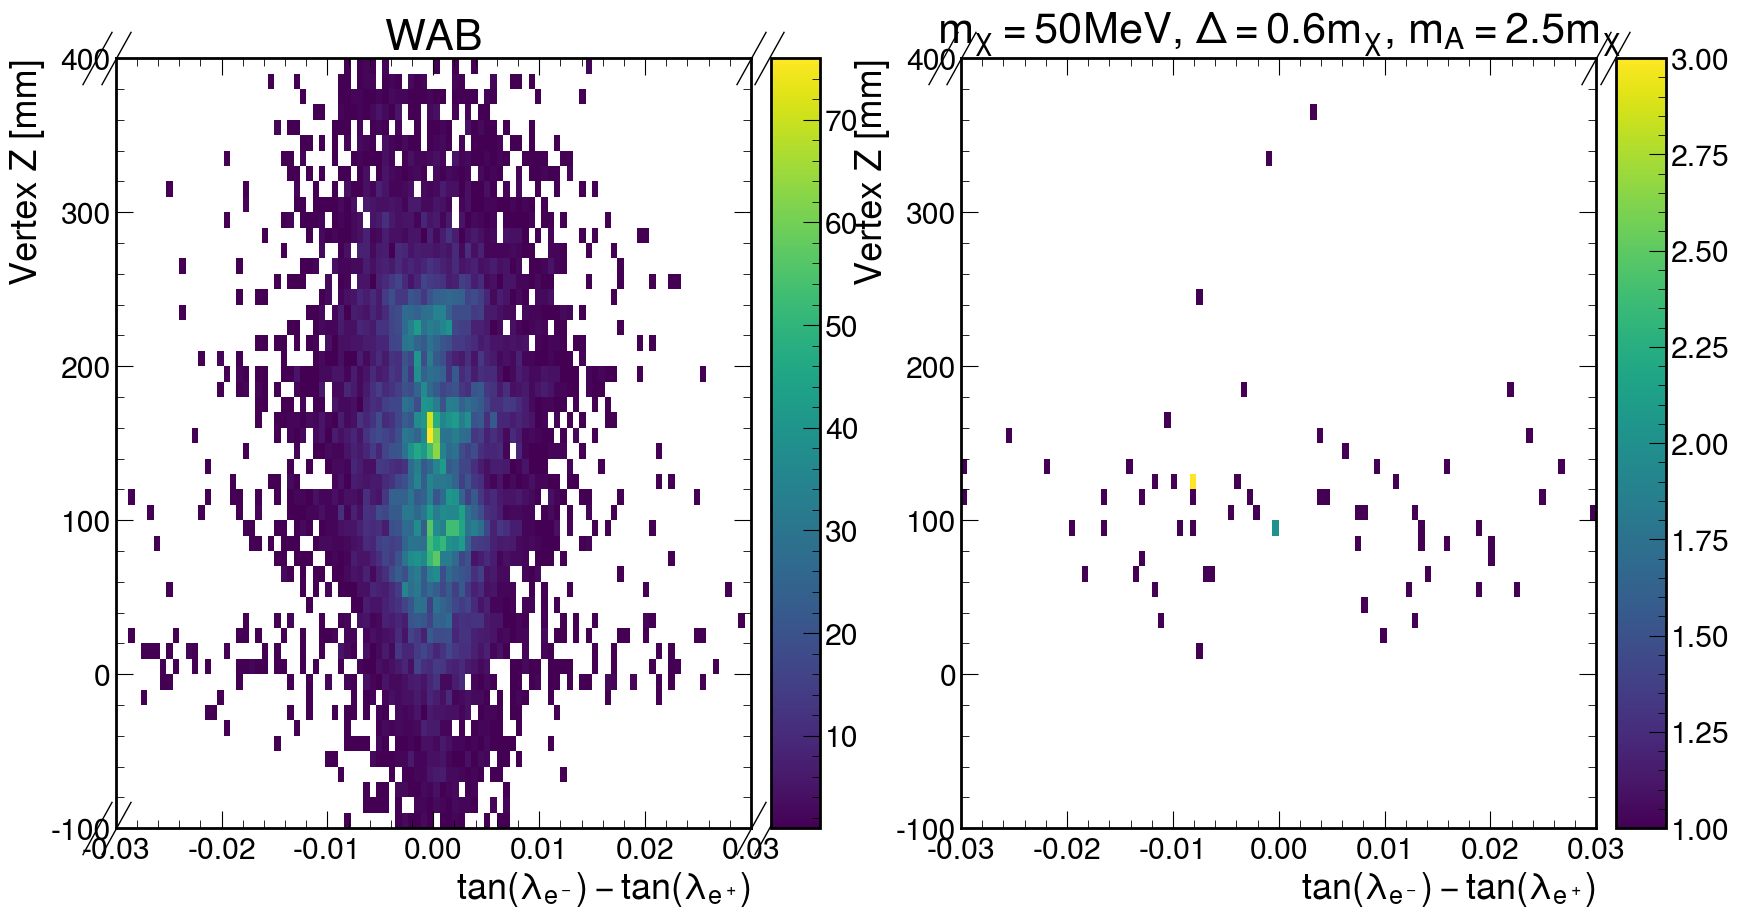

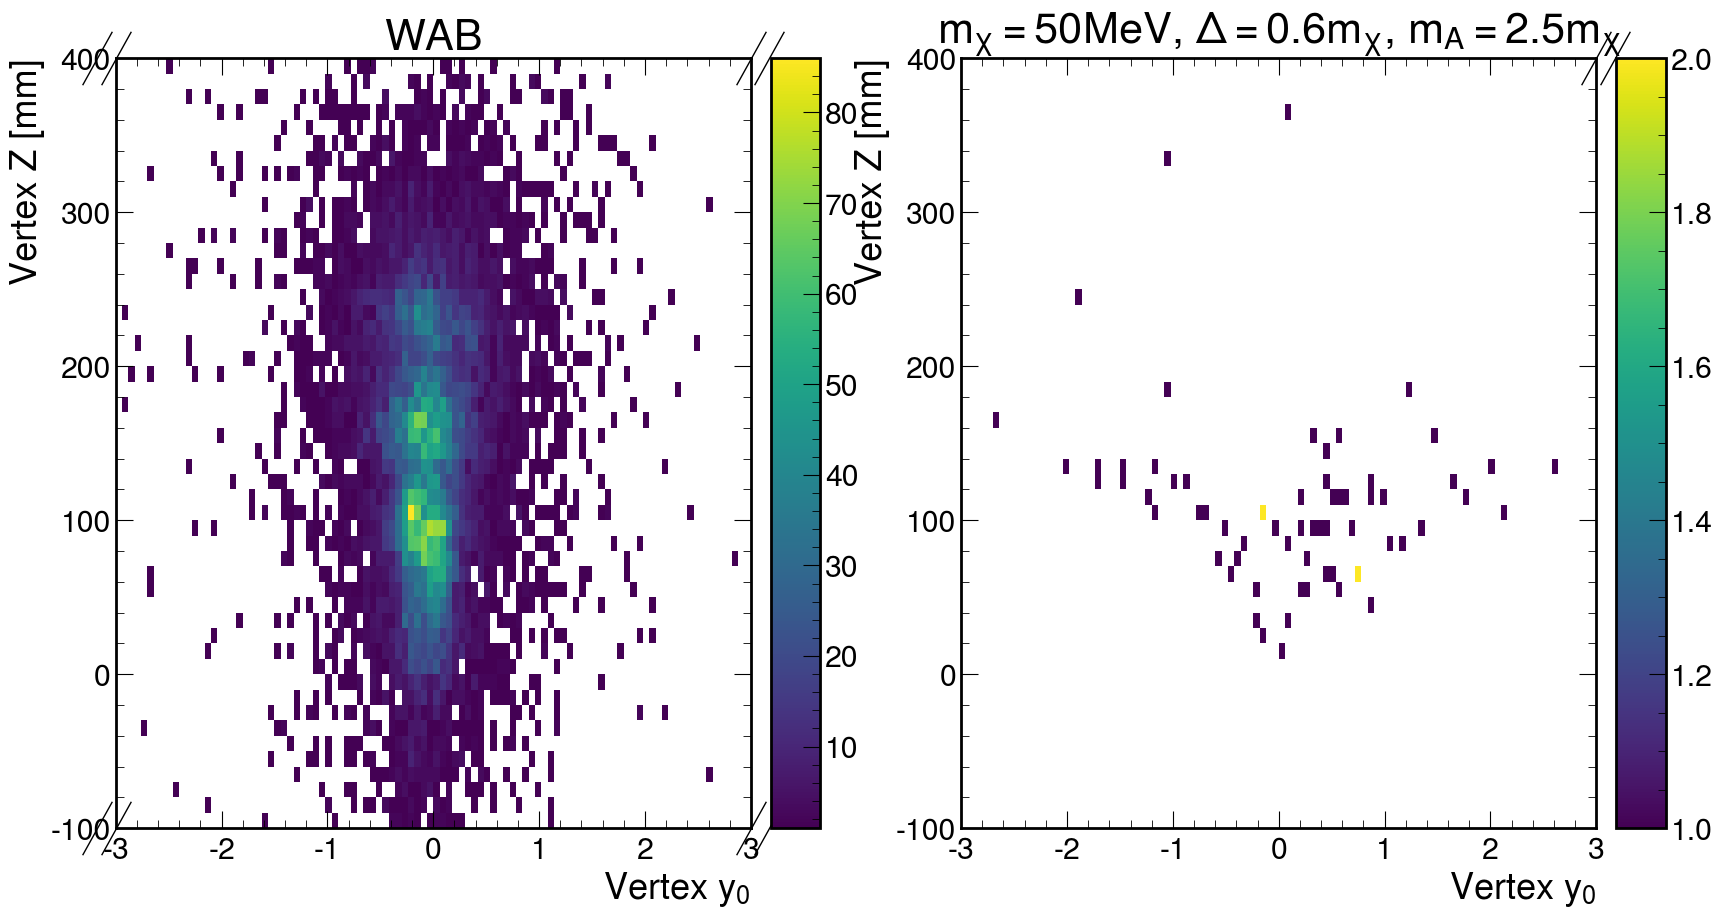

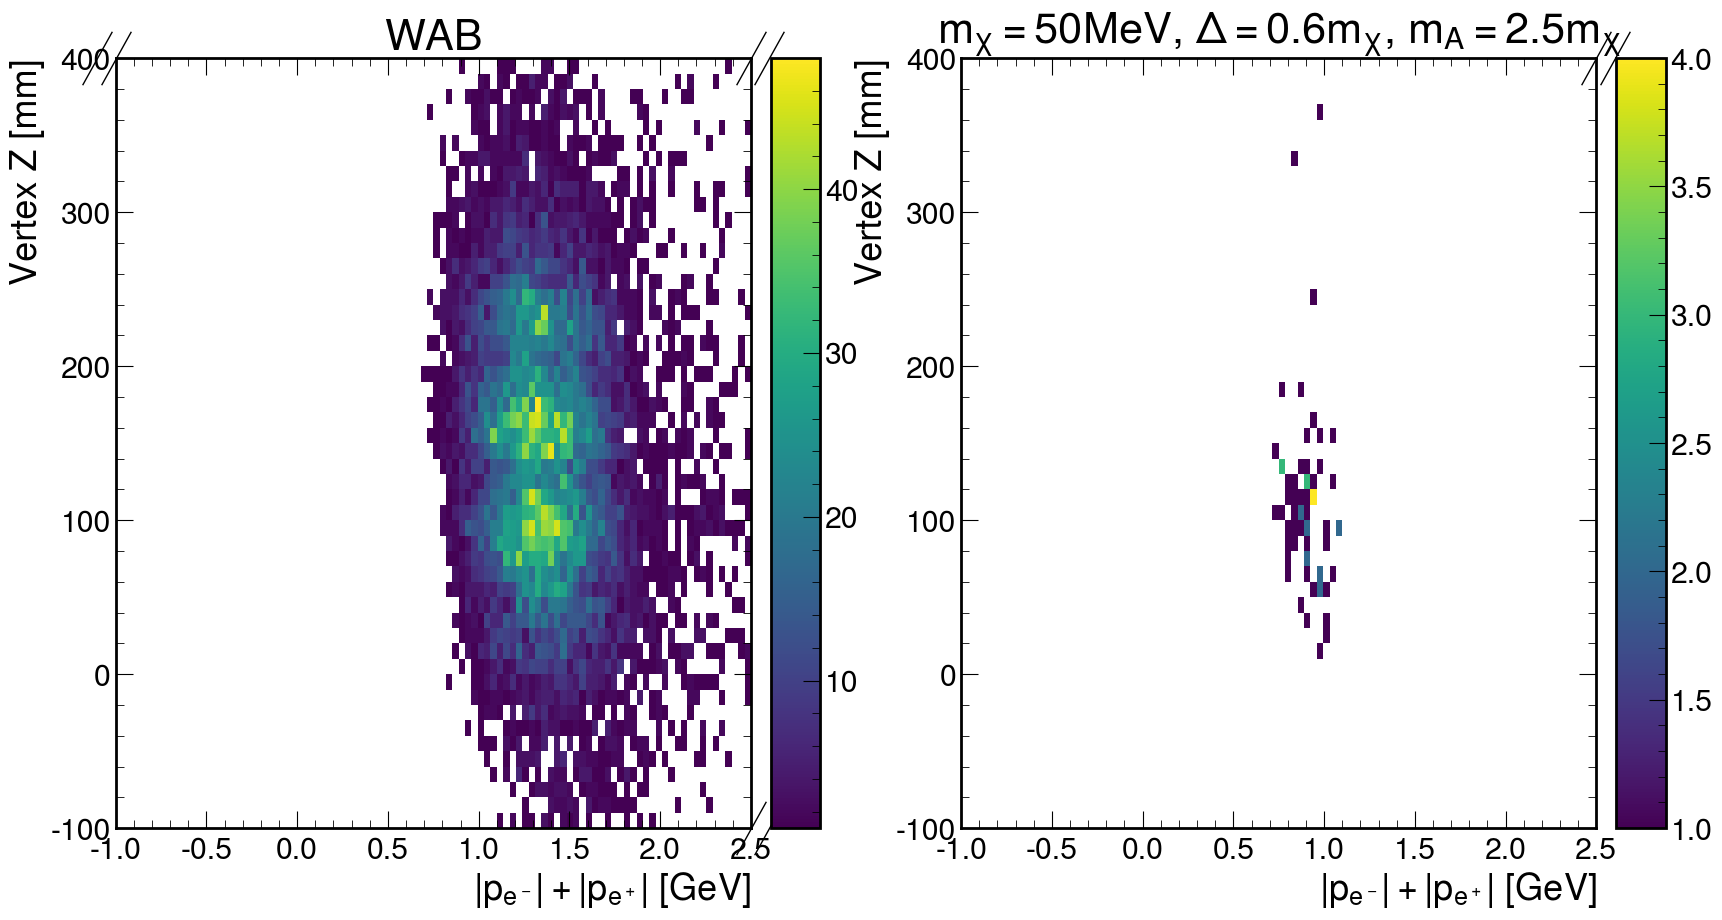

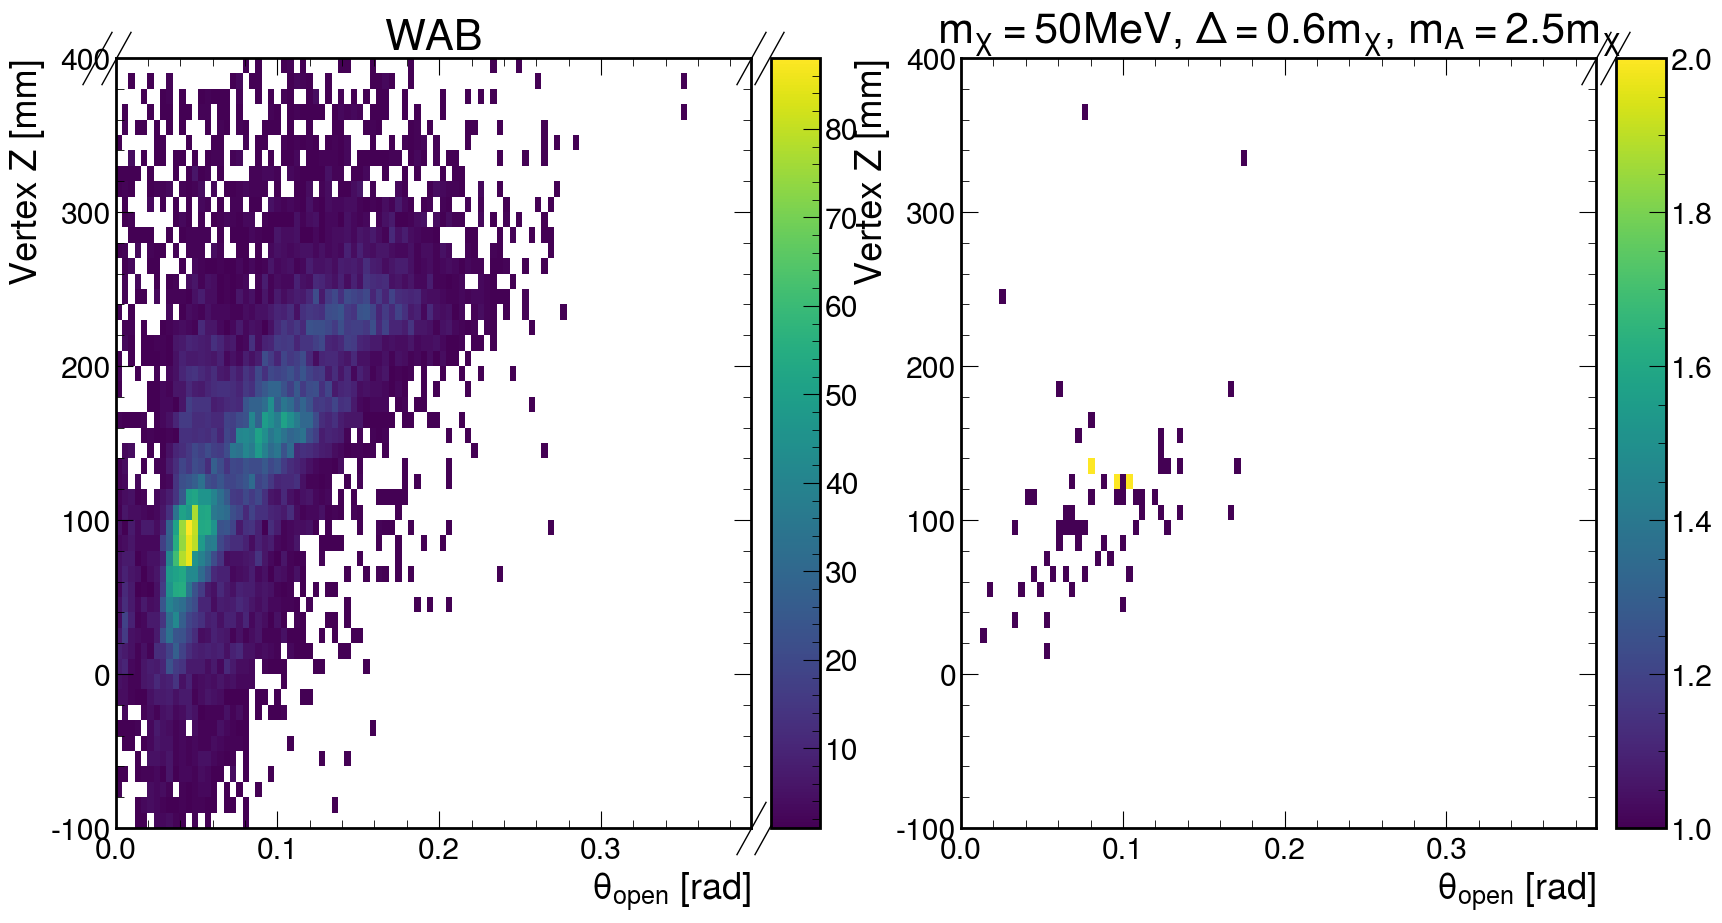

In [6]:
for var in ['invM','dtanLambda','y0','psum','angle']: #,'tripsum']:
    fig, (wab, sig) = plt.subplots(
        ncols=2,
        figsize=(20,10)
    )
    d['wab-beam'][f'cvtx_vs_{var}'].plot(ax=wab,cmin=1)
    wab.set_title('WAB')
    d[(50.0,0.6,2.5)][f'cvtx_vs_{var}'].plot(ax=sig,cmin=1)
    sig.set_title('$m_\\chi = $50MeV, $\Delta = 0.6m_\\chi$, $m_A = 2.5m_\\chi$')
    fig.savefig(f'plots/cvtx_vs_{var}.pdf', bbox_inches='tight')
    plt.show()

In [5]:
with open('conv-vertex-ana.pkl','rb') as f:
    d = pickle.load(f)

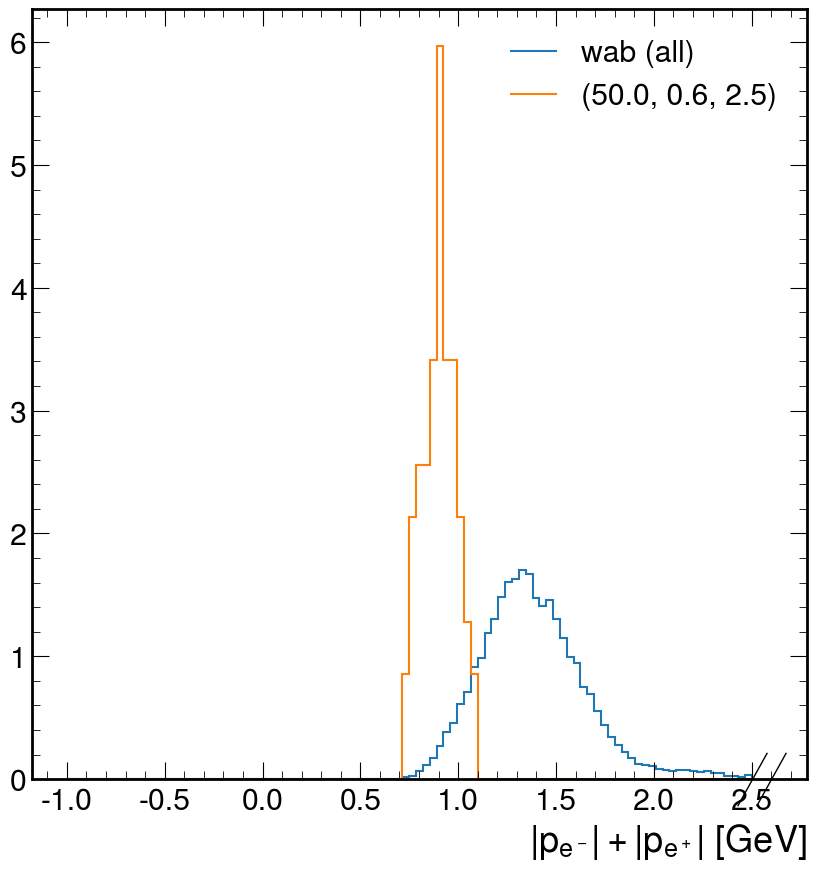

In [6]:
d['wab-beam']['cvtx_vs_psum'][:,sum].plot(label='wab (all)', density=True)
d[(50.0,0.6,2.5)]['cvtx_vs_psum'][:,sum].plot(label=f'{(50.0,0.6,2.5)}', density=True)
plt.legend()
plt.show()

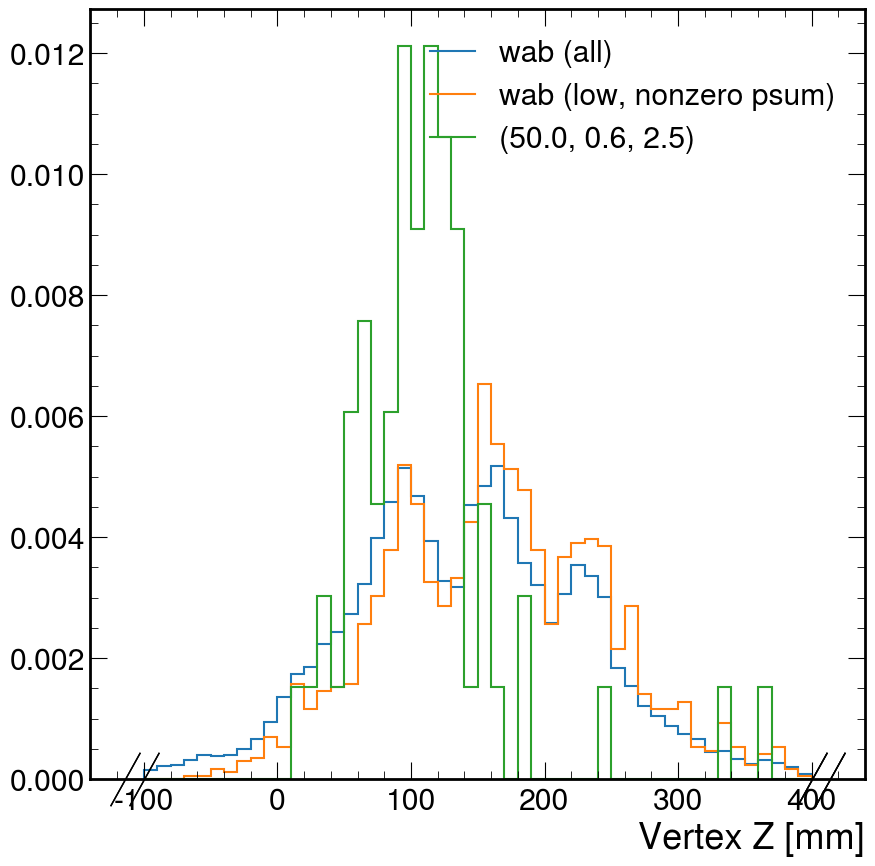

In [74]:
d['wab-beam']['cvtx_vs_psum'][sum,:].plot(label='wab (all)', density=True)
d['wab-beam']['cvtx_vs_psum'][:1.1j:sum,:].plot(label='wab (low, nonzero psum)', density=True)
d[(50.0,0.6,2.5)]['cvtx_vs_psum'][:1.1j:sum,:].plot(label=f'{(50.0,0.6,2.5)}', density=True)
plt.legend()
plt.show()

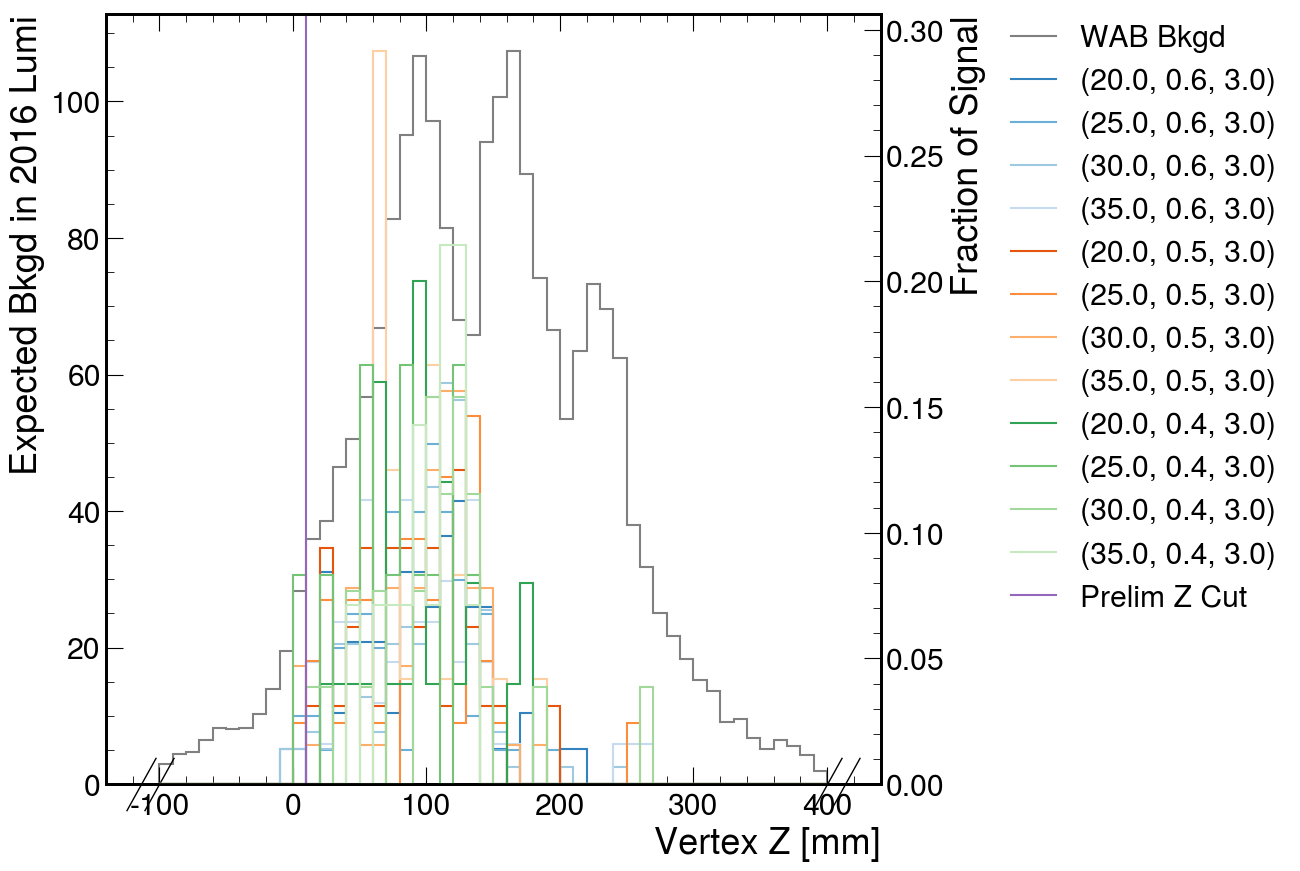

In [125]:
fig, bkgd = plt.subplots()

lumi = 10.7 #pb^(-1)
wab_scale = 0.1985e12*lumi/(100000*9966)
wab_wsum = d['wab-beam']['cvtx']['selected',sum,:].sum(flow=True)
bkgd_h = d['wab-beam']['cvtx']['selected',sum,:]/wab_wsum*wab_scale
bkgd_h.plot(ax=bkgd, color='gray', label='WAB Bkgd')
bkgd.set_ylabel('Expected Bkgd in 2016 Lumi')

sign = bkgd.twinx()
sign.set_ylabel('Fraction of Signal')

signals = [
    (20.0,0.6,3.0),
    (25.0,0.6,3.0),
    (30.0,0.6,3.0),
    (35.0,0.6,3.0),
    (20.0,0.5,3.0),
    (25.0,0.5,3.0),
    (30.0,0.5,3.0),
    (35.0,0.5,3.0),
    (20.0,0.4,3.0),
    (25.0,0.4,3.0),
    (30.0,0.4,3.0),
    (35.0,0.4,3.0),
]
from cycler import cycler
cm = mpl.colormaps['tab20c']
sign.set_prop_cycle(cycler(color=[cm(v/20) for v in range(len(signals))]))
for sig in signals:
    (
        d[sig]['cvtx']['selected',sum,:] 
        / d[sig]['cvtx']['selected',sum,:].sum(flow=True)
#        * rate_maxima.set_index(['mchi','rdmchi','rmap']).loc[sig].mean()
    ).plot(ax=sign, label=f'{sig}')

plt.axvline(10.0, label='Prelim Z Cut', color='tab:purple')
fig.legend(
    loc='upper left',
    bbox_to_anchor=(1,0.9)
)
#fig.savefig('plots/conv-vtx-z.pdf', bbox_inches='tight')
plt.show()

In [9]:
with open('conv-vertex-ana-roacc.pkl','rb') as f:
    r = pickle.load(f)

In [10]:
r['signal']['roacc'][(r['signal']['roacc'].mchi==50)&(r['signal']['roacc'].rdmchi==0.6)&(r['signal']['roacc'].rmap==2.5)]

,eps2,mchi,rdmchi,rmap,num_thrown,prod_rate,std_num_pass,std_reweightsum,std_reweightsum_pass,mod_num_pass,mod_reweightsum,mod_reweightsum_pass,std_z_cut_eff,std_event_selection_eff,std_full_eff,std_full_rate,mod_z_cut_eff,mod_event_selection_eff,mod_full_eff,mod_full_rate
87,0.000001,50.0,0.6,2.5,4000000,7.011854e+03,4158,2.740962,0.888014,67,3.739371e-02,3.739371e-02,0.323979,0.00104,3.367763e-04,2.361426,1.0,0.000017,0.000017,0.117449
213,0.000001,50.0,0.6,2.5,4000000,8.461854e+03,4158,3.269185,1.056004,67,4.452959e-02,4.452959e-02,0.323017,0.00104,3.357766e-04,2.841293,1.0,0.000017,0.000017,0.141736
339,0.000001,50.0,0.6,2.5,4000000,1.021170e+04,4158,3.890019,1.252021,67,5.288291e-02,5.288291e-02,0.321855,0.00104,3.345681e-04,3.416510,1.0,0.000017,0.000017,0.171046
465,0.000002,50.0,0.6,2.5,4000000,1.232341e+04,4158,4.615740,1.479109,67,6.259784e-02,6.259784e-02,0.320449,0.00104,3.331066e-04,4.105009,1.0,0.000017,0.000017,0.206417
591,0.000002,50.0,0.6,2.5,4000000,1.487180e+04,4158,5.458521,1.739895,67,7.380651e-02,7.380651e-02,0.318748,0.00104,3.313389e-04,4.927606,1.0,0.000017,0.000017,0.249103
717,0.000003,50.0,0.6,2.5,4000000,1.794718e+04,4158,6.429534,2.036175,67,8.661238e-02,8.661238e-02,0.316691,0.00104,3.292002e-04,5.908214,1.0,0.000017,0.000017,0.300615
843,0.000003,50.0,0.6,2.5,4000000,2.165852e+04,4158,7.537685,2.368349,67,1.010668e-01,1.010668e-01,0.314201,0.00104,3.266120e-04,7.073933,1.0,0.000017,0.000017,0.362780
969,0.000004,50.0,0.6,2.5,4000000,2.613734e+04,4158,8.787912,2.734690,67,1.171381e-01,1.171381e-01,0.311188,0.00104,3.234796e-04,8.454897,1.0,0.000017,0.000017,0.437801
1095,0.000004,50.0,0.6,2.5,4000000,3.154236e+04,4158,10.179073,3.130480,67,1.346723e-01,1.346723e-01,0.307541,0.00104,3.196886e-04,10.083732,1.0,0.000017,0.000017,0.528334
1221,0.000005,50.0,0.6,2.5,4000000,3.806508e+04,4158,11.701508,3.547064,67,1.533475e-01,1.533475e-01,0.303129,0.00104,3.151024e-04,11.994398,1.0,0.000017,0.000017,0.637590


2.0 0.4
2.0 0.5
2.0 0.6
2.4 0.4
2.4 0.5
2.4 0.6
2.5 0.4
2.5 0.5
2.5 0.6
2.6 0.4
2.6 0.5
2.6 0.6
3.0 0.4
3.0 0.5
3.0 0.6


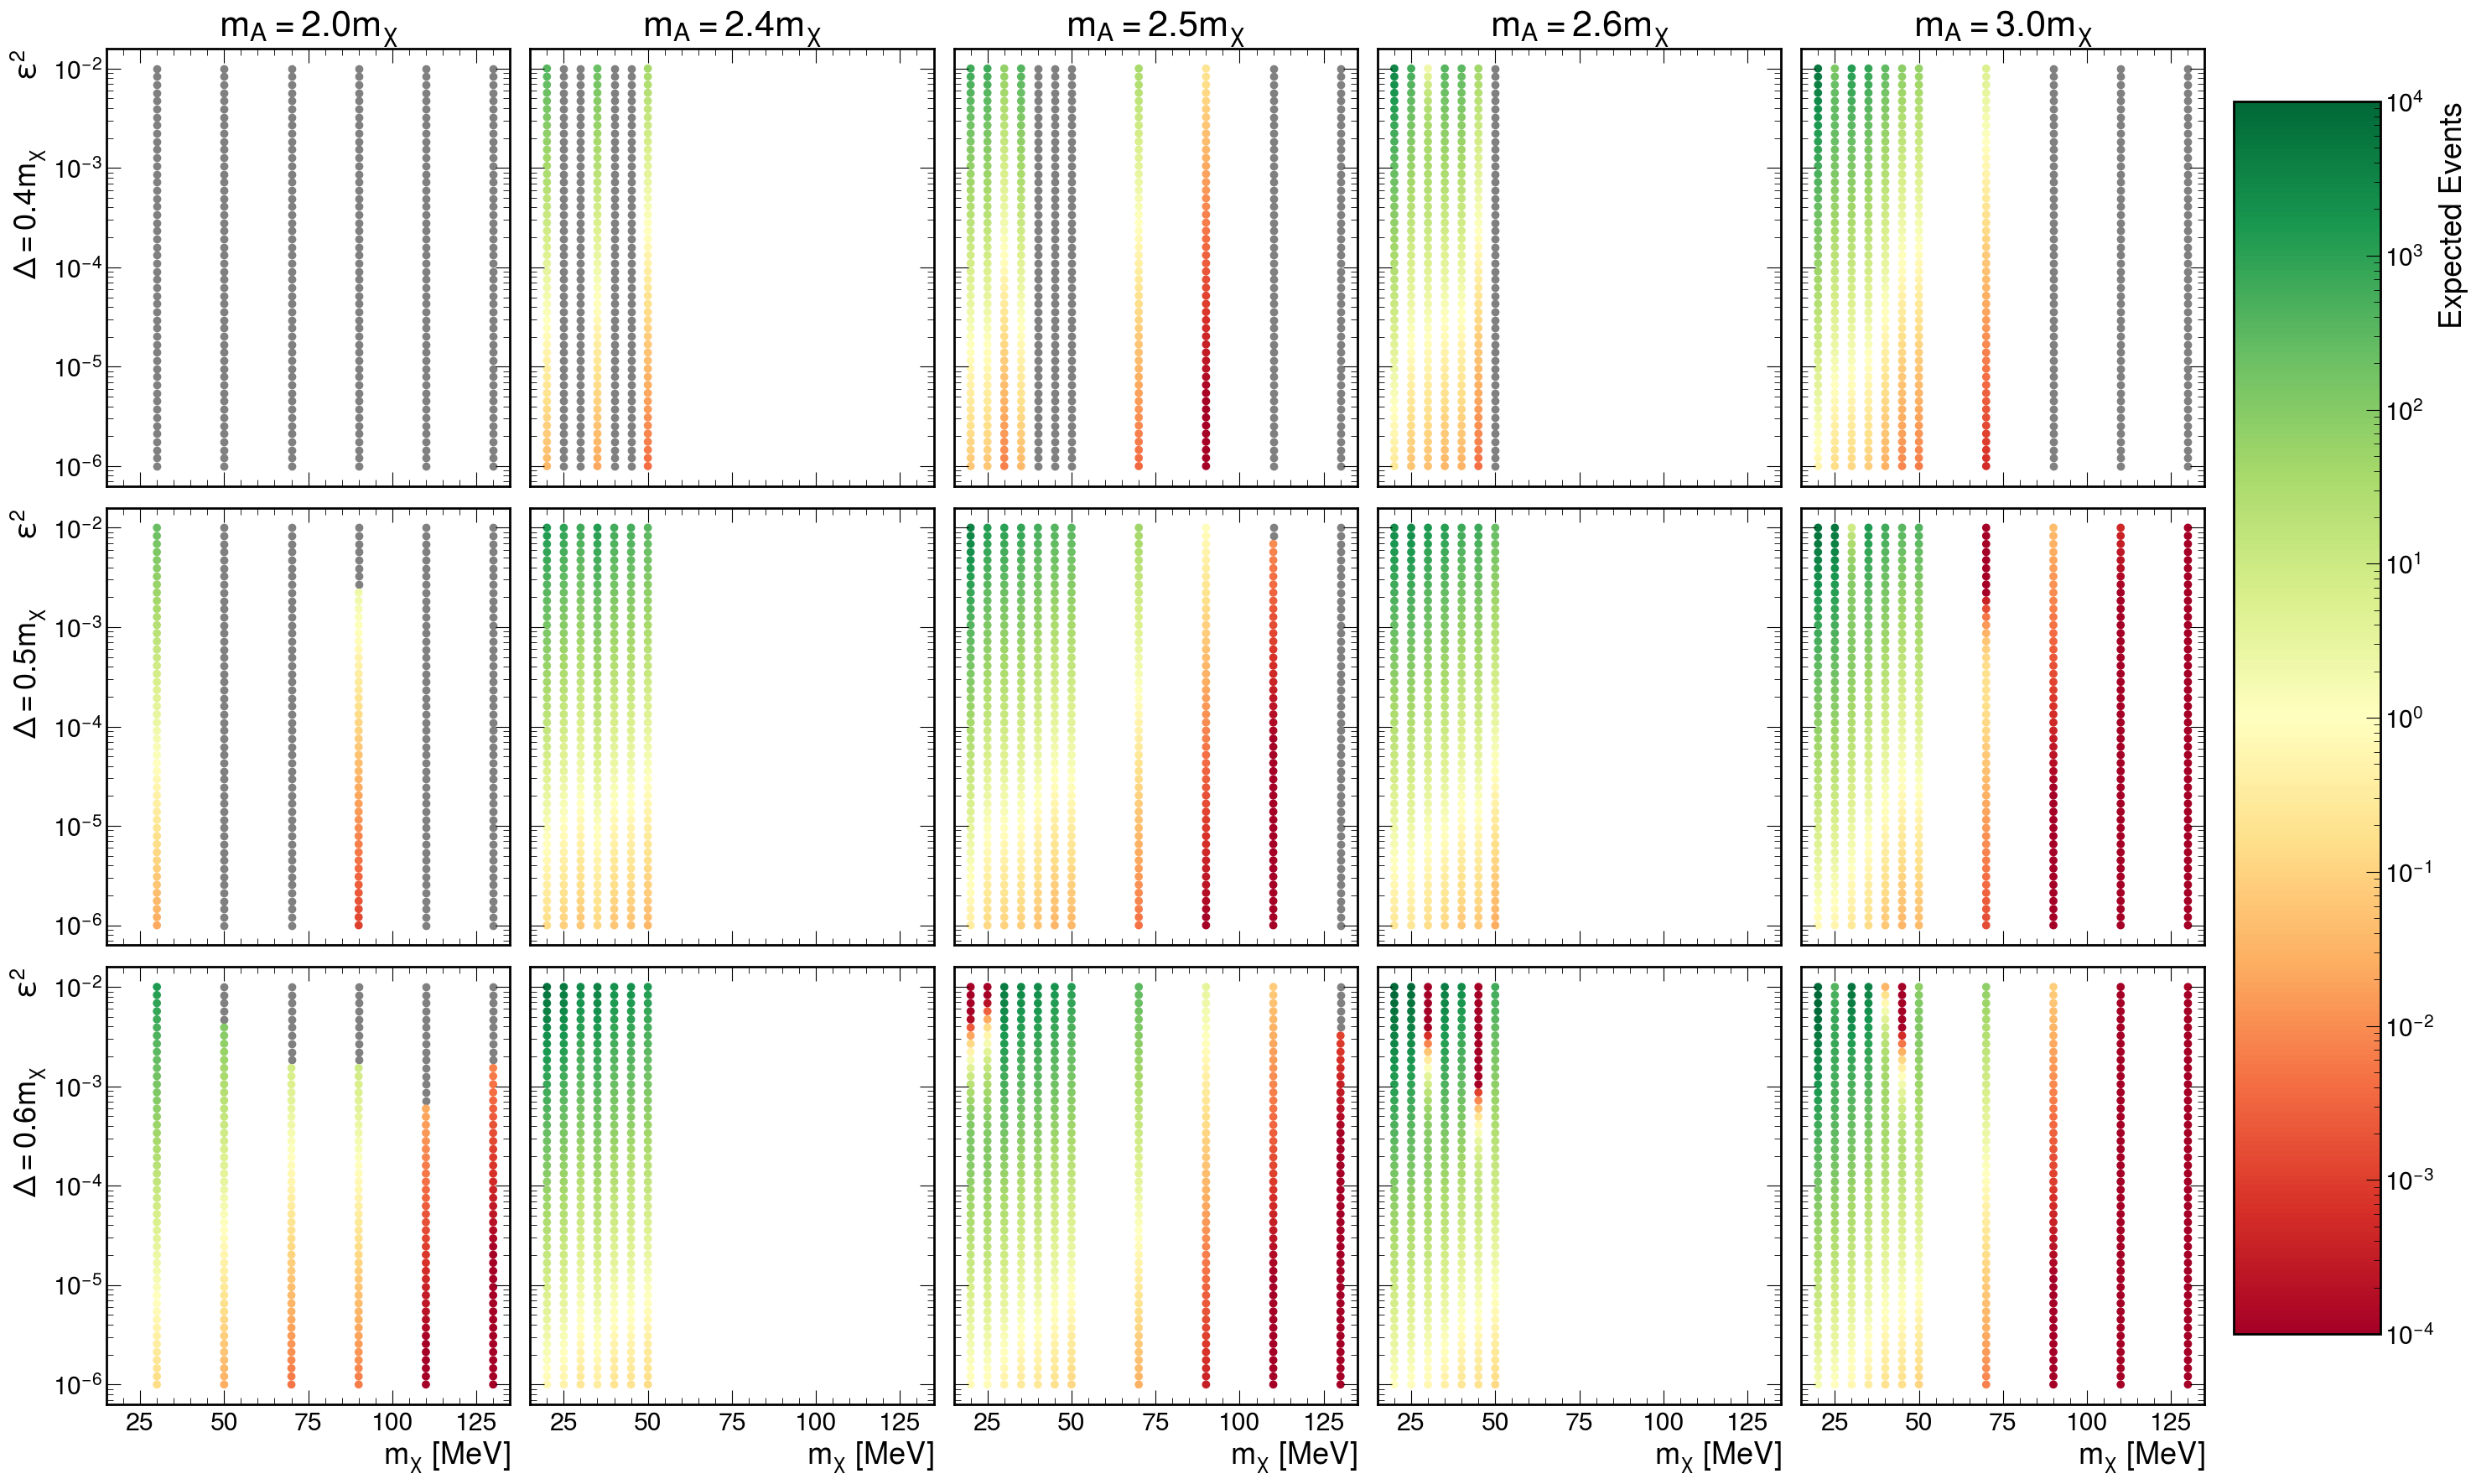

In [106]:
rmaps = np.unique(r['signal']['roacc'].rmap)
rdmchis = np.unique(r['signal']['roacc'].rdmchi)

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

fig, axes = plt.subplots(
    nrows=len(rdmchis),
    ncols=len(rmaps),
    sharex = 'col',
    sharey = 'row',
    figsize = (7*len(rmaps),7*len(rdmchis)),
    gridspec_kw = dict(
        wspace = 0.05,
        hspace = 0.05
    )
)

for (rdmchi, rmap), ax in zip(
    cartesian_product(rdmchis, rmaps),
    axes.flatten()
):
    sl = r['signal']['roacc'][(
        (r['signal']['roacc'].rdmchi==rdmchi)
        &(r['signal']['roacc'].rmap==rmap)
    )]
    zero_events = np.isnan(sl.mod_full_rate)|~np.any(sl.mod_full_rate)
    ax.scatter(sl.mchi[zero_events], sl.eps2[zero_events],
               color='gray')
    im = ax.scatter(sl.mchi[~zero_events], sl.eps2[~zero_events], c=sl.mod_full_rate[~zero_events],
                    norm=mpl.colors.LogNorm(1e-4, 1e4),
                    cmap='RdYlGn')
    ax.set_yscale('log')
    ax.set_xlim(xmin=15,xmax=135)

for rmap, ax in zip(rmaps, axes[0]):
    ax.set_title(f'$m_A = {rmap}m_\\chi$')

for irow, rdmchi in enumerate(rdmchis):
    axes[irow][0].set_ylabel(f'$\Delta = {rdmchi}m_\\chi$        $\epsilon^2$')
    
for ax in axes[-1]:
    ax.set_xlabel('$m_\\chi$ [MeV]')

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Expected Events')
fig.savefig('plots/idm-reach-survey.pdf', bbox_inches='tight')
plt.show()

In [14]:
rate_maxima = r['signal']['roacc'].groupby(['rdmchi','rmap','mchi']).mod_full_rate.max().reset_index()

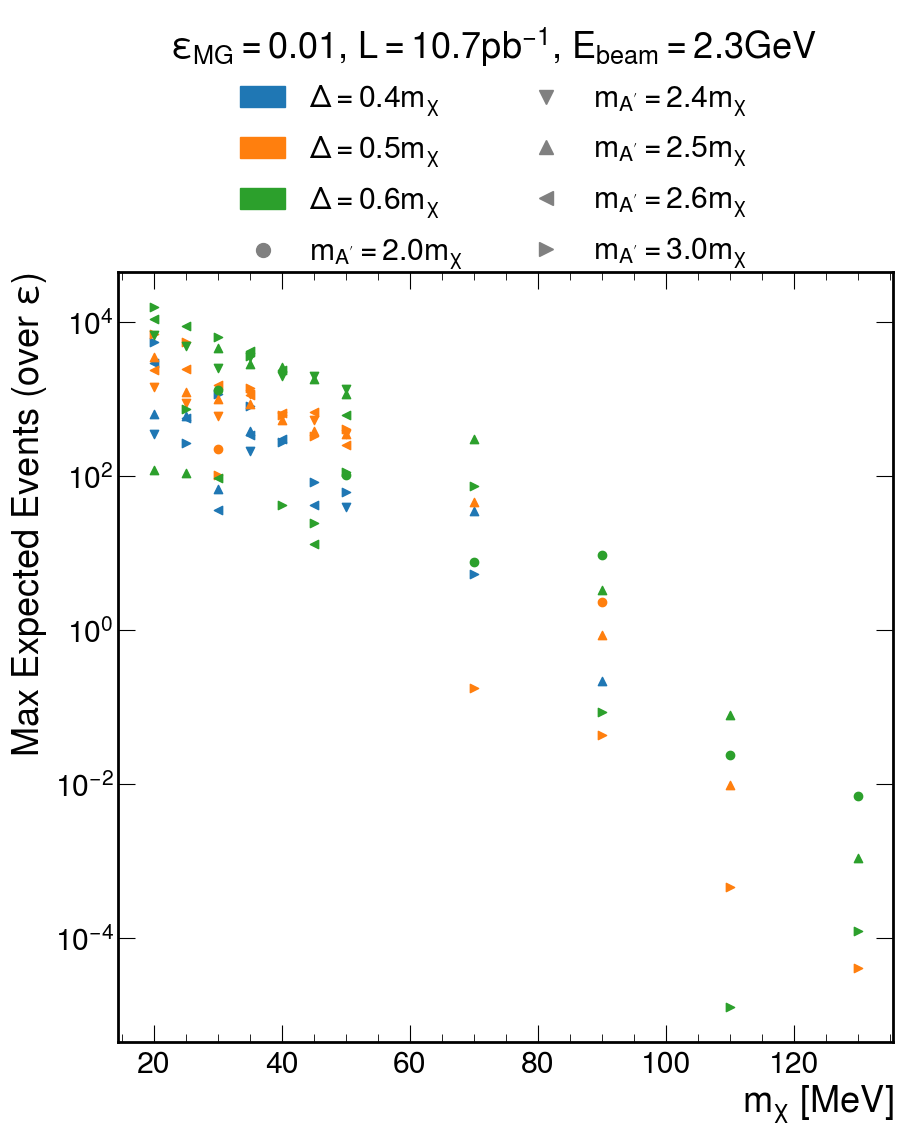

In [15]:
rdmchi = list(np.unique(rate_maxima.rdmchi))
rdmchi.sort()
colors = { r : c for r,c in zip(rdmchi, list(mpl.colors.TABLEAU_COLORS.keys())[:len(rdmchi)])}

rmaps = list(np.unique(rate_maxima.rmap))
rmaps.sort()
markers = { r : m for r, m in zip(rmaps, mpl.lines.Line2D.filled_markers[1:len(rmaps)+1]) }

# fig, axes = plt.subplots(
#     nrows = 2,
#     sharex = True,
#     gridspec_kw = dict(
#         hspace = 0,
#         bottom=0, top=1, left=0, right=1
#     )
# )
fig, ax = plt.subplots()

for rdmchi, color in colors.items():
    for rmap, marker in markers.items():
        sl=rate_maxima[(rate_maxima.rdmchi==rdmchi)&(rate_maxima.rmap==rmap)]
        if sum(sl.mod_full_rate) == 0:
            continue
        ax.scatter(sl.mchi, sl.mod_full_rate,
            color = color,
            marker = marker
        )
ax.set_yscale('log')

legend_artists = []
for rdmchi, color in colors.items():
    legend_artists.append(
        mpl.patches.Patch(
            facecolor=color, edgecolor=color, 
            label=f'$\\Delta = {rdmchi}m_\\chi$'
        )
    )
for rmap, marker in markers.items():
    legend_artists.append(
        mpl.lines.Line2D(
            [0],[0],
            marker = marker, color='gray', lw=0,
            markersize=10,
            label=f'$m_{{A\'}}={rmap}m_\\chi$'
        )
    )

fig.legend(
    title='$\\epsilon_\\mathrm{MG}=0.01$, $\\mathcal{L}=10.7\\mathrm{pb}^{-1}$, $E_\\mathrm{beam}=2.3$GeV',
    handles=legend_artists,
    ncols=2,
    loc='lower center',
    bbox_to_anchor=(0.5,0.85)
)

ax.set_xlabel('$m_\\chi$ [MeV]')
ax.set_ylabel('Max Expected Events (over $\\epsilon$)')
#fig.savefig('plots/maximum-reach.pdf', bbox_inches='tight')
plt.show()

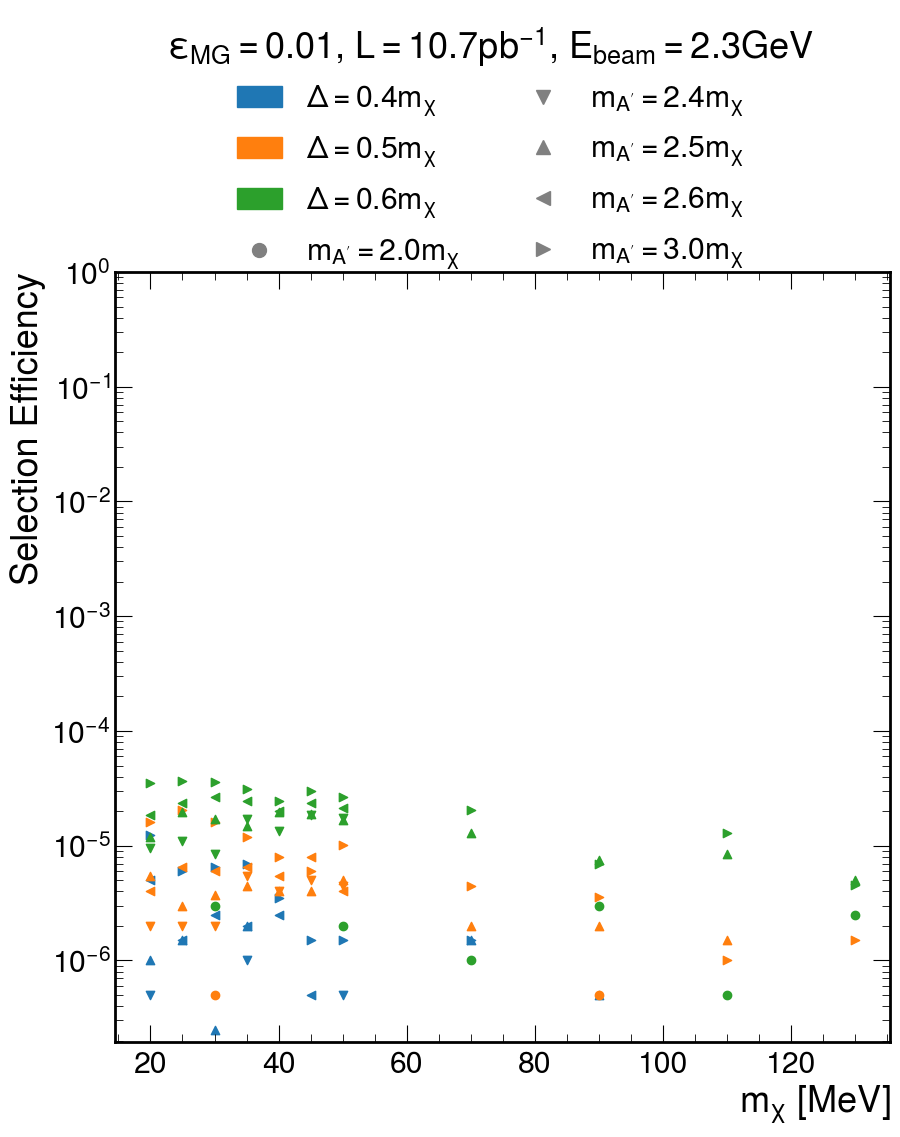

In [18]:
mod_to_std = r['signal']['roacc'].groupby(['rdmchi','rmap','mchi']).agg({'num_thrown':np.mean,'mod_num_pass':np.mean,'std_num_pass':np.mean}).reset_index()

mod_to_std['mod_eff'] = mod_to_std.mod_num_pass/mod_to_std.num_thrown
mod_to_std['ratio'] = mod_to_std.mod_num_pass/mod_to_std.std_num_pass

# fig, axes = plt.subplots(
#     nrows = 2,
#     sharex = True,
#     gridspec_kw = dict(
#         hspace = 0,
#         bottom=0, top=1, left=0, right=1
#     )
# )
fig, ax = plt.subplots()

for rdmchi, color in colors.items():
    for rmap, marker in markers.items():
        sl=mod_to_std[(mod_to_std.rdmchi==rdmchi)&(mod_to_std.rmap==rmap)]
        ax.scatter(sl.mchi, sl.mod_eff,
            color = color,
            marker = marker
        )
ax.set_yscale('log')

legend_artists = []
for rdmchi, color in colors.items():
    legend_artists.append(
        mpl.patches.Patch(
            facecolor=color, edgecolor=color, 
            label=f'$\\Delta = {rdmchi}m_\\chi$'
        )
    )
for rmap, marker in markers.items():
    legend_artists.append(
        mpl.lines.Line2D(
            [0],[0],
            marker = marker, color='gray', lw=0,
            markersize=10,
            label=f'$m_{{A\'}}={rmap}m_\\chi$'
        )
    )

fig.legend(
    title='$\\epsilon_\\mathrm{MG}=0.01$, $\\mathcal{L}=10.7\\mathrm{pb}^{-1}$, $E_\\mathrm{beam}=2.3$GeV',
    handles=legend_artists,
    ncols=2,
    loc='lower center',
    bbox_to_anchor=(0.5,0.85)
)

ax.set_ylim(ymax=1)
ax.set_xlabel('$m_\\chi$ [MeV]')
ax.set_ylabel('Selection Efficiency')
fig.savefig('plots/cvtx-selection-efficiency', bbox_inches='tight')
plt.show()

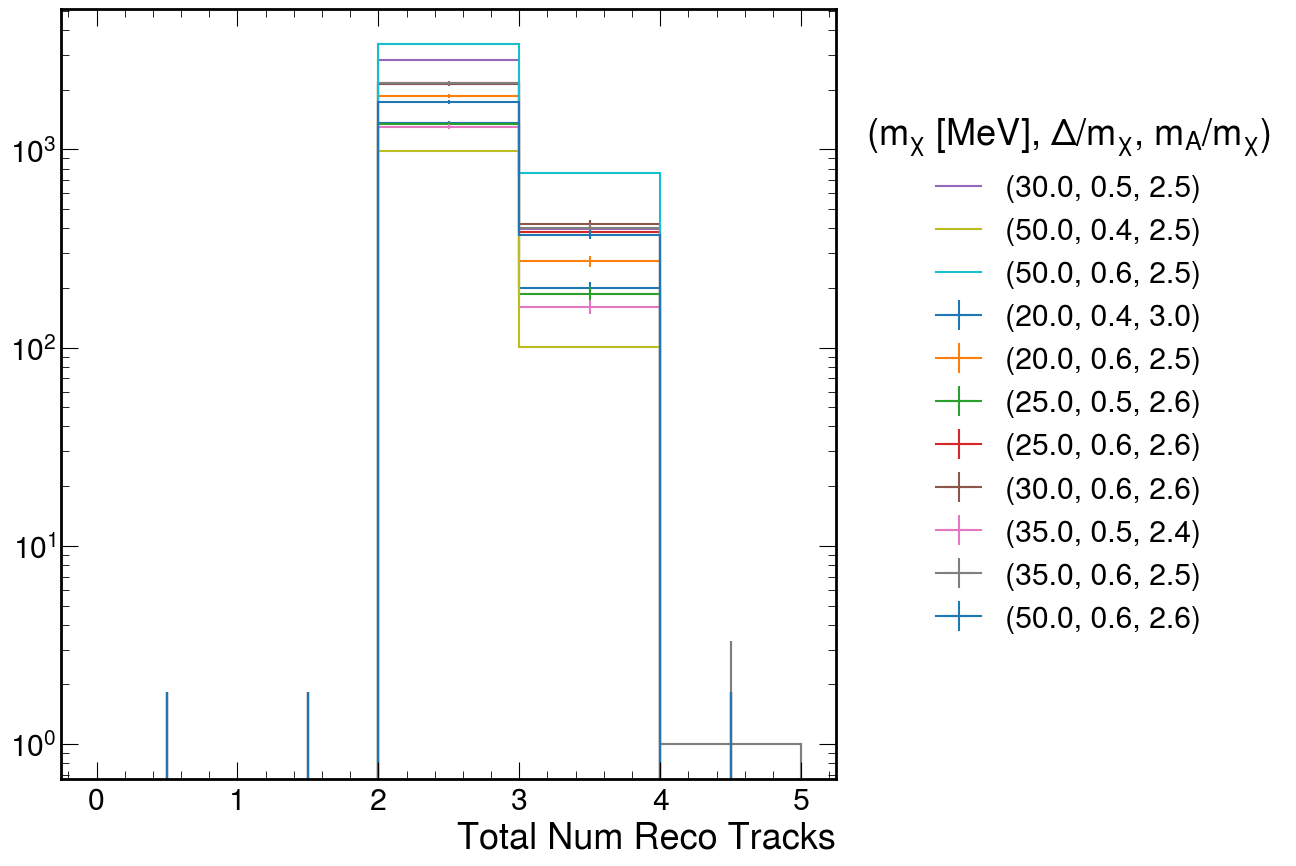

In [154]:
fig, ax = plt.subplots()
# ax.set_prop_cycle(
#     color=colors,
# )

ntracks = [
    (key, val.n_trks)
    for key, val in out.items()
    if isinstance(key, tuple)
]
ntracks.sort(key = lambda entry : entry[0])

for (mchi, rdmchi, rmap), h in ntracks:
    if rate_maxima[(rate_maxima.mchi==mchi)&(rate_maxima.rdmchi==rdmchi)&(rate_maxima.rmap==rmap)].full_rate.iloc[0] > 1.0:
        h.plot(label=f'{(mchi,rdmchi,rmap)}')
plt.legend(
    title='($m_\\chi$ [MeV], $\Delta/m_\\chi$, $m_{A}/m_\\chi$)',
    loc='upper left',
    bbox_to_anchor=(1.,0.9)
)
plt.yscale('log')
plt.savefig('plots/max-reach-over-1-n-tracks.pdf',bbox_inches='tight')
plt.show()